#Random Forest Implementation Through sklearn

##Loading Necessary Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import math

##Loading dataset

In [11]:
df = pd.read_csv("Data.csv",index_col=0)
df.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ,TARGET CLASS
0,0.913917,1.162073,0.567946,0.755464,0.780862,0.352608,0.759697,0.643798,0.879422,1.231409,1
1,0.635632,1.003722,0.535342,0.825645,0.924109,0.648450,0.675334,1.013546,0.621552,1.492702,0
2,0.721360,1.201493,0.921990,0.855595,1.526629,0.720781,1.626351,1.154483,0.957877,1.285597,0
3,1.234204,1.386726,0.653046,0.825624,1.142504,0.875128,1.409708,1.380003,1.522692,1.153093,1
4,1.279491,0.949750,0.627280,0.668976,1.232537,0.703727,1.115596,0.646691,1.463812,1.419167,1


In [12]:
X = df.drop('TARGET CLASS', axis=1)
y = df['TARGET CLASS'] 

##Standardize the Variables

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df.drop('TARGET CLASS',axis=1))
scaled_features = scaler.transform(df.drop('TARGET CLASS',axis=1))

In [14]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])
df_feat.head()

,WTT,PTI,EQW,SBI,LQE,QWG,FDJ,PJF,HQE,NXJ
0,-0.123542,0.185907,-0.913431,0.319629,-1.033637,-2.308375,-0.798951,-1.482368,-0.949719,-0.643314
1,-1.084836,-0.430348,-1.025313,0.625388,-0.444847,-1.152706,-1.129797,-0.202240,-1.828051,0.636759
2,-0.788702,0.339318,0.301511,0.755873,2.031693,-0.870156,2.599818,0.285707,-0.682494,-0.377850
3,0.982841,1.060193,-0.621399,0.625299,0.452820,-0.267220,1.750208,1.066491,1.241325,-1.026987
4,1.139275,-0.640392,-0.709819,-0.057175,0.822886,-0.936773,0.596782,-1.472352,1.040772,0.276510


##Splitting data into train, test and cross validation set

In [15]:
X = scaled_features
y = df['TARGET CLASS']

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.2)

print('Total number of datapoints in the dataset:',X.shape[0])

print('Number of datapoints in Training data: {}({:.2f}%)'.
      format(X_tr.shape[0],(X_tr.shape[0]/X.shape[0])*100))

print('Number of datapoints in Cross Validation data: {}({:.2f}%)'.
      format(X_cv.shape[0],(X_cv.shape[0]/X.shape[0])*100))

print('Number of datapoints in Test Data: {}({:.2f}%)'.
      format(X_test.shape[0],(X_test.shape[0]/X.shape[0])*100))

Total number of datapoints in the dataset: 1000
Number of datapoints in Training data: 560(56.00%)
Number of datapoints in Cross Validation data: 140(14.00%)
Number of datapoints in Test Data: 300(30.00%)


#Random Forest model building along with hyperparameter tuning using GridSearchCV

In [16]:
#Performing gridsearch on no. of base learners and max depth only.

base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}

rf = RandomForestClassifier(max_features='sqrt')
model=GridSearchCV(rf,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model.fit(X_tr,y_tr)

print("Optimal n_estimators",model.best_estimator_.n_estimators)
print("Optimal max_depth",model.best_estimator_.max_depth)

Optimal n_estimators 100
Optimal max_depth 500


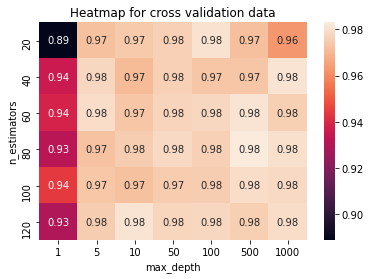

In [18]:
# Plotting heatmaps to understand optimal no. of estimators and max depth better

X=[]
Y=[]
Z=[]
Zt=[]
for bl in base_learners:
    for d in depths:
        rf=RandomForestClassifier(max_features='sqrt',max_depth=d,n_estimators=bl)
        rf.fit(X_tr,y_tr)
        pred=rf.predict_proba(X_cv)[:,1]
        predt=rf.predict_proba(X_tr)[:,1]
        X.append(bl)
        Y.append(d)
        Z.append(roc_auc_score(y_cv,pred))
        Zt.append(roc_auc_score(y_tr,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Z})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

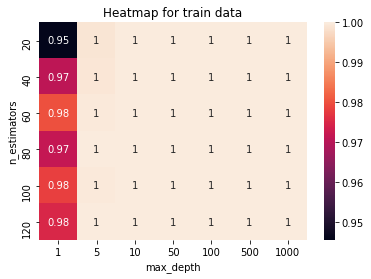

In [19]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': Zt})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

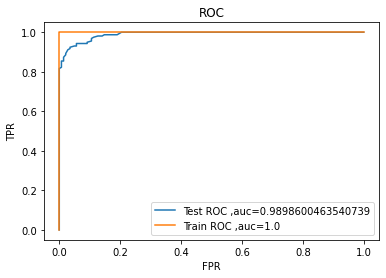

In [17]:
#Plotting ROC curve

rf=RandomForestClassifier(max_features='sqrt',max_depth=model.best_estimator_.max_depth,
                          n_estimators=model.best_estimator_.n_estimators)
rf.fit(X_tr,y_tr)
predi=rf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred=rf.predict_proba(X_tr)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr,pred)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

##Evaluation metrics

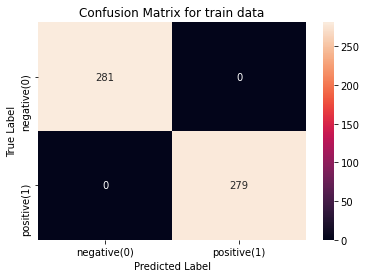



-------------------- Metric report for train data --------------------

               precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       1.00      1.00      1.00       279

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560



In [22]:
#Confusion matrix using heatmap for train data

predic=rf.predict(X_tr)

conf_mat = confusion_matrix(y_tr, predic)
class_label = ["negative(0)", "positive(1)"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for train data','-'*20)
print('\n',classification_report(y_tr,predic))

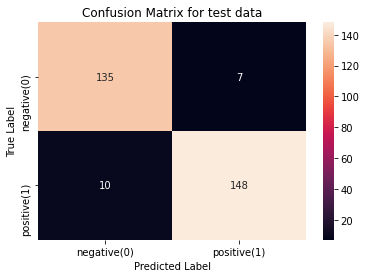



-------------------- Metric report for test data --------------------

               precision    recall  f1-score   support

           0       0.93      0.95      0.94       142
           1       0.95      0.94      0.95       158

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



In [23]:
#Confusion matrix using heatmap for test data

predic=rf.predict(X_test)

conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative(0)", "positive(1)"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True,fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('\n')
print('-'*20,'Metric report for test data','-'*20)
print('\n',classification_report(y_test,predic))